### PyTorch Dataset Loader with Augmentations

In [1]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as T
import os

# Image size for ResNet
IMAGE_SIZE = 224

# Define transform pipeline
train_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet standard
])

val_test_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Paths
data_path = "dataset/facial hair"
batch_size = 32

# Datasets
train_ds = ImageFolder(root=os.path.join(data_path, 'Train'), transform=train_transform)
val_ds = ImageFolder(root=os.path.join(data_path, 'Validate'), transform=val_test_transform)
test_ds = ImageFolder(root=os.path.join(data_path, 'Test'), transform=val_test_transform)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Class labels
print("Class to index mapping:", train_ds.class_to_idx)


Class to index mapping: {'Beard': 0, 'No Beard': 1}


### Load & Modify ResNet18

In [2]:
import torch
import torch.nn as nn
from torchvision import models

# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2)  # Binary output
)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Confirm architecture
print(model)


c:\anaconda\envs\mv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\anaconda\envs\mv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Dataset Wrapper for Label Remapping

In [3]:
from torch.utils.data import Dataset
import random

class BinaryFacialHairDataset(Dataset):
    def __init__(self, base_dataset, original_class_map):
        self.base_dataset = base_dataset
        self.original_class_map = original_class_map

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        # Map Beard -> 1, No Beard -> 0
        new_label = 1 if label == self.original_class_map['Beard'] else 0
        return image, new_label


#### Applying Wrapper

In [4]:
# # Map: {'Beard': 0, 'No Beard': 1}
# original_class_map = train_ds.class_to_idx

# Wrap datasets
train_ds_remap = BinaryFacialHairDataset(train_ds, train_ds.class_to_idx)
val_ds_remap   = BinaryFacialHairDataset(val_ds, val_ds.class_to_idx)
test_ds_remap  = BinaryFacialHairDataset(test_ds, test_ds.class_to_idx)

# New loaders
train_loader = DataLoader(train_ds_remap, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds_remap, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds_remap, batch_size=batch_size, shuffle=False)


### Training Loop

In [5]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Loss = {running_loss:.4f}, Accuracy = {acc:.2f}%")


Epoch 1: Loss = 13.6288, Accuracy = 60.84%
Epoch 2: Loss = 13.0703, Accuracy = 67.24%
Epoch 3: Loss = 12.5241, Accuracy = 72.54%
Epoch 4: Loss = 11.6448, Accuracy = 73.32%
Epoch 5: Loss = 10.6477, Accuracy = 75.82%
Epoch 6: Loss = 10.0448, Accuracy = 78.63%
Epoch 7: Loss = 11.3749, Accuracy = 73.79%
Epoch 8: Loss = 8.9803, Accuracy = 81.44%
Epoch 9: Loss = 8.4871, Accuracy = 82.22%
Epoch 10: Loss = 9.5045, Accuracy = 81.28%
Epoch 11: Loss = 10.3866, Accuracy = 76.76%
Epoch 12: Loss = 7.6510, Accuracy = 85.34%
Epoch 13: Loss = 8.2894, Accuracy = 83.00%
Epoch 14: Loss = 9.5031, Accuracy = 80.66%
Epoch 15: Loss = 8.5575, Accuracy = 83.31%
Epoch 16: Loss = 9.5465, Accuracy = 82.06%
Epoch 17: Loss = 6.6764, Accuracy = 87.68%
Epoch 18: Loss = 6.9252, Accuracy = 85.96%
Epoch 19: Loss = 6.2124, Accuracy = 89.55%
Epoch 20: Loss = 6.6213, Accuracy = 86.74%
Epoch 21: Loss = 6.4838, Accuracy = 87.21%
Epoch 22: Loss = 7.3048, Accuracy = 85.80%
Epoch 23: Loss = 7.0519, Accuracy = 86.74%
Epoch 24: Lo

### Evaluatoin

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


def evaluate_model(model, loader, title="Validation"):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(f"\nEvaluation on {title} Set")
    print(classification_report(y_true, y_pred, target_names=["No Beard", "Beard"]))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Beard", "Beard"],
                yticklabels=["No Beard", "Beard"])
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



Evaluation on Validation Set
              precision    recall  f1-score   support

    No Beard       0.71      1.00      0.83         5
       Beard       1.00      0.60      0.75         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10



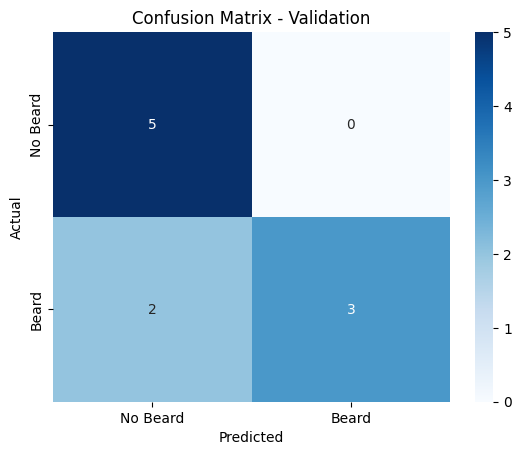


Evaluation on Test Set
              precision    recall  f1-score   support

    No Beard       0.75      0.90      0.82        10
       Beard       0.88      0.70      0.78        10

    accuracy                           0.80        20
   macro avg       0.81      0.80      0.80        20
weighted avg       0.81      0.80      0.80        20



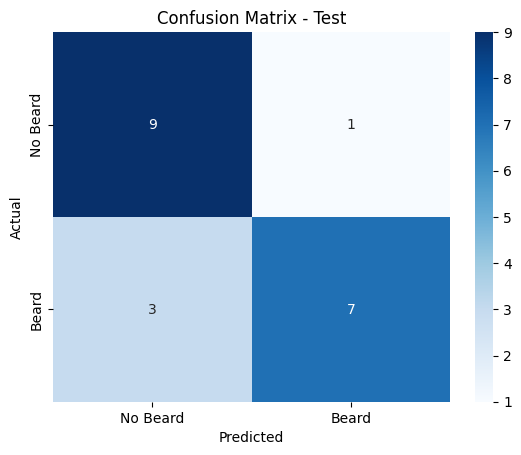

In [7]:
evaluate_model(model, val_loader, title="Validation")
evaluate_model(model, test_loader, title="Test")


In [9]:
torch.save(model.state_dict(), "resnet_facial_hair_binary.pt")
print("Model saved as 'resnet_facial_hair_binary.pt'")


Model saved as 'resnet_facial_hair_binary.pt'
